In [5]:
import os
import sys
import math
import glob

import numpy as np
import pandas as pd
import geopandas as gpd
import h3pandas
import shapely
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..')
sys.path.append(PROJECT_SRC_PATH)

from gtfs2nx import network, score, utils



In [6]:
scores = {}
files = glob.glob('../results-eu/access-score-*.gpkg')

for f in files:
    city = f.split('-')[3]
    scores[city] = gpd.read_file(f)


In [7]:
pop = {}
files = glob.glob('../data-xml/income_pop_count/*_income_pop_count.gpkg')

for f in files:
    city = f.split('/')[-1].split('_')[0]
    pop[city] = gpd.read_file(f)


<AxesSubplot: >

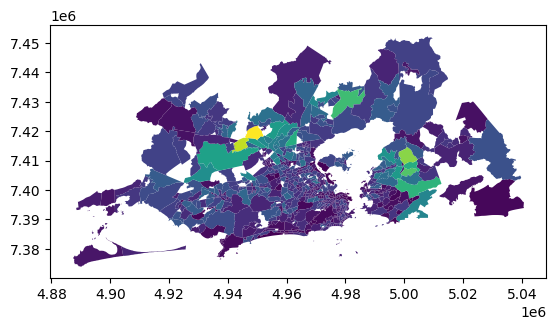

In [89]:
pop['Rio'].plot('Population Count')

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/plotting.p

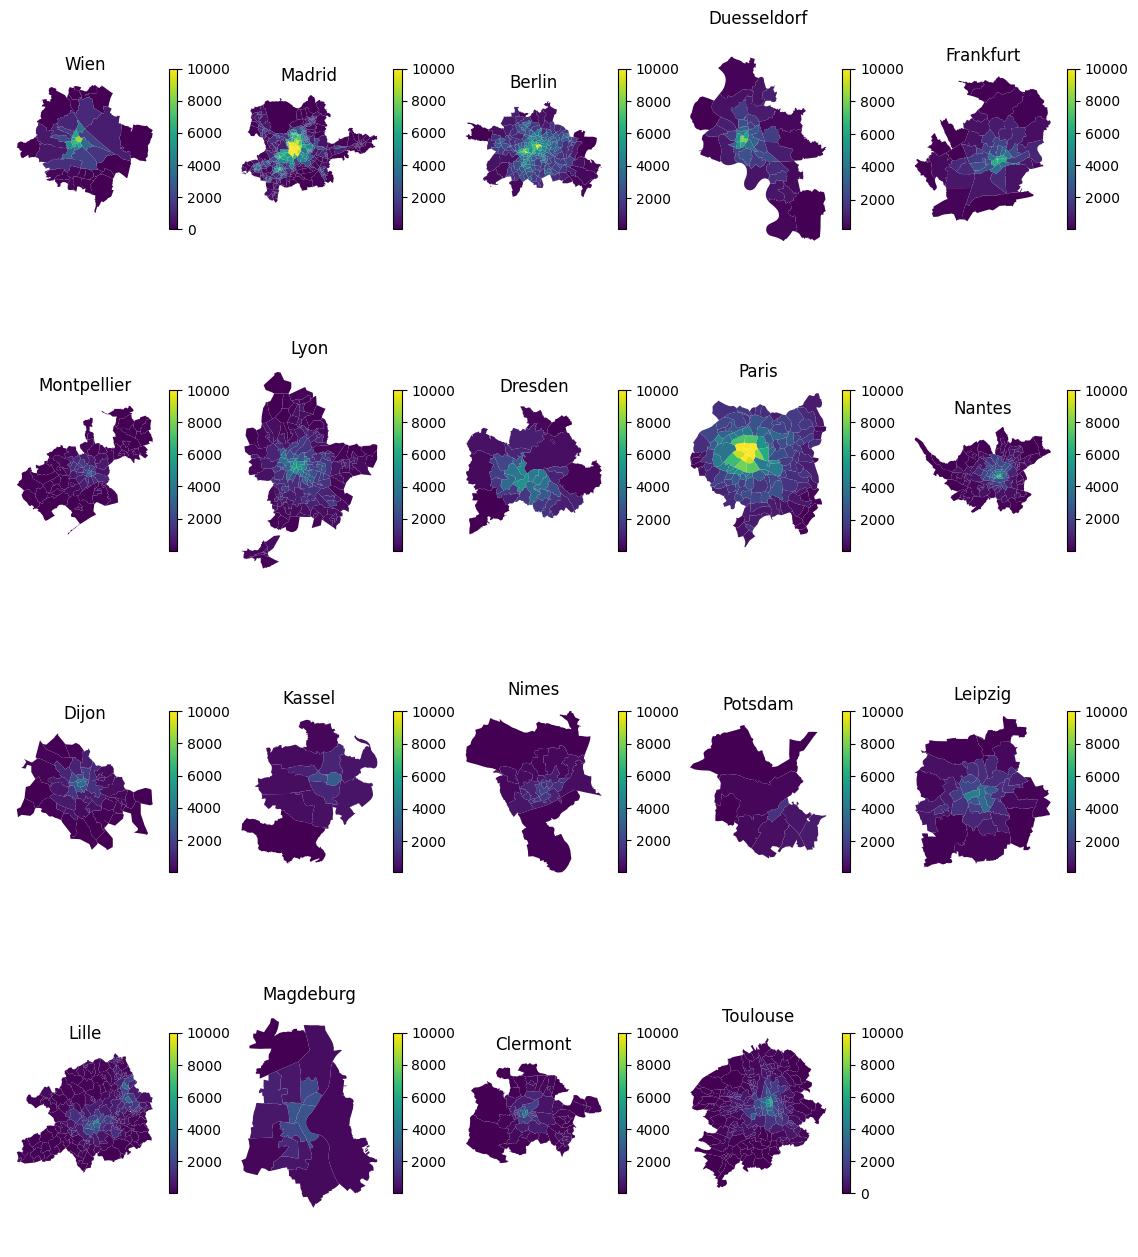

In [10]:

%matplotlib inline
ncols = 5
nrows = math.ceil(len(scores.values()) / ncols)
_, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, nrows * 4))

for i, (city, score) in enumerate(scores.items()):
    # if city == 'Madrid':
    #     continue

    ax = axs[math.floor(i / ncols), i % ncols]

    # score = pd.merge(score, pop[city][['tractid', 'Population Count']], on='tractid')
    # score = score[distance_to_centroid(score) < 10000] # needs population count to determine the center

    ax = score.plot(column='score_spatiotemporal', vmax=10000, legend=True, ax=ax, legend_kwds={'shrink': 0.6})
    ax.set_title(city)
    ax.set_axis_off()

for ax in axs.ravel():
    ax.set_axis_off()



/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

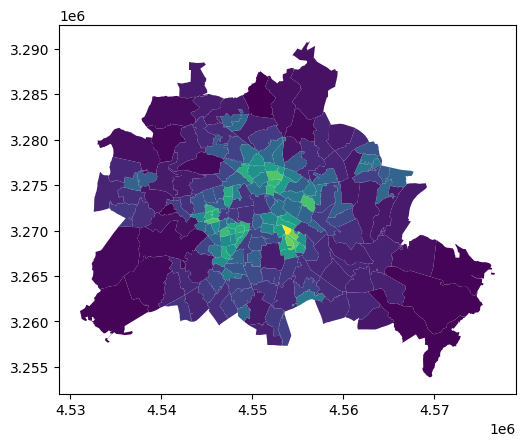

In [8]:
berlin = scores['Berlin']

# Berlin zip codes
population = pd.read_csv('../../predictive-modeling/data/population-density-berlin-zip-code.csv', sep=';', decimal=',')
population = population[['zip_code', 'total']]
population = population.groupby('zip_code')['total'].sum().rename('population')
berlin = pd.merge(berlin, population, left_on='geocode', right_index=True)
berlin['pop_density'] = berlin['population'] / berlin.geometry.area
berlin.plot('pop_density')



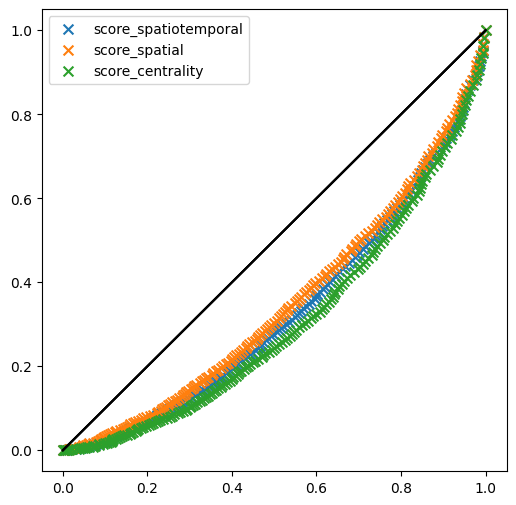

In [130]:
def lorenz_curve(df, x, y, ax=None, kwargs={}):
    df = df.sort_values(y, ascending=True)
    X = df[x].cumsum() / df[x].sum()
    Y = df[y].cumsum() / df[y].sum()
    X = np.insert(X, 0, 0)
    Y = np.insert(Y, 0, 0)

    if ax is None:
        _, ax = plt.subplots(figsize=[6,6])

    # Lorenz curve scatter plot
    ax.scatter(X, Y, marker='x', s=50, **kwargs)
    ax.legend()
    
    # plot line of equality
    ax.plot([0,1], [0,1], color='k')


_, ax = plt.subplots(figsize=[6,6])
lorenz_curve(berlin, 'population', 'score_spatiotemporal', ax=ax, kwargs={'label': 'score_spatiotemporal'})
lorenz_curve(berlin, 'population', 'score_spatial', ax=ax, kwargs={'label': 'score_spatial'})
lorenz_curve(berlin, 'population', 'score_centrality', ax=ax, kwargs={'label': 'score_centrality'})

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Text(0.5, 1.0, 'Rank difference between \n spatiotemporal and centrality-enhanced accessibility')

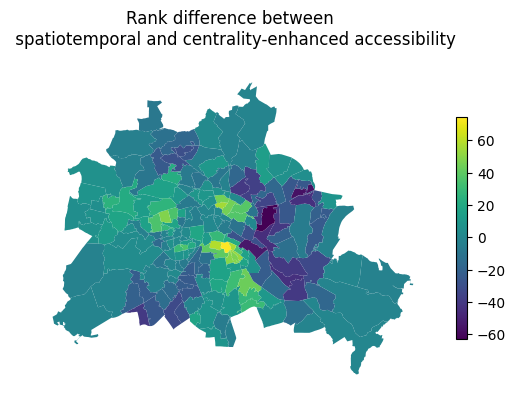

In [30]:
# berlin['score_spatiotemporal_rank'] = berlin['score_spatiotemporal'].rank()
# berlin.sort_values('score_spatiotemporal_rank', ascending=False).head(10)

berlin['rank_diff'] = berlin['score_centrality'].rank() - berlin['score_spatial'].rank()
ax = berlin.plot('rank_diff', legend=True, legend_kwds={'shrink': 0.6})
ax.set_axis_off()
ax.set_title('Rank difference between \n spatiotemporal and centrality-enhanced accessibility')

In [120]:
def distance_to_centroid(df):
    df['pop_density'] = df['Population Count'] / df.geometry.area
    center = df.loc[df['pop_density'].idxmax()].geometry.centroid
    return df.geometry.centroid.apply(lambda g: g.distance(center))


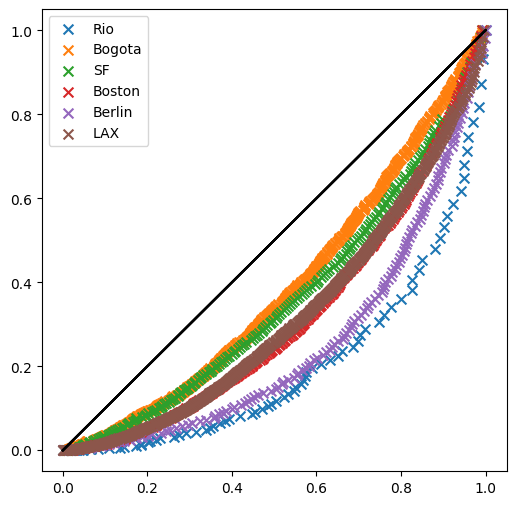

In [115]:
_, ax = plt.subplots(figsize=[6,6])
for city, score in scores.items():
    score = pd.merge(score, pop[city][['tractid', 'Population Count']], on='tractid')
    score['distance_center'] = distance_to_centroid(score)
    score = score[score['distance_center'] < 10000]
    lorenz_curve(score, 'Population Count', 'score_spatiotemporal', ax=ax, kwargs={'label': city})
    